In [1]:
import pandas as pd
import numpy as np
import cv2
import skimage
from skimage import exposure, transform
from skimage.transform import resize
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

import tensorflow
from tensorflow import keras
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

In [2]:
train_df = pd.read_csv("BoneAge.csv")

train_df.head()

,id,boneage,male
0,1386,30,False
1,1392,162,True
2,1397,18,False
3,1401,132,False
4,1410,57,True


In [3]:
# train_df = train_df.drop("male", axis=1)

train_df.head()

,id,boneage,male
0,1386,30,False
1,1392,162,True
2,1397,18,False
3,1401,132,False
4,1410,57,True


In [4]:
train_df["file_paths"] = train_df["id"].apply(lambda x: "./data/validation/" + str(x) + ".png")

train_df.head()

,id,boneage,male,file_paths
0,1386,30,False,./data/validation/1386.png
1,1392,162,True,./data/validation/1392.png
2,1397,18,False,./data/validation/1397.png
3,1401,132,False,./data/validation/1401.png
4,1410,57,True,./data/validation/1410.png


In [5]:
def find_valid_files(file_path):
    try:
        imread(file_path)
        return 1
    except FileNotFoundError:
        return 0
    
train_df["valid"] = train_df["file_paths"].apply(lambda x: find_valid_files(x))
train_df = train_df[train_df["valid"] == 1]
train_df = train_df.drop("valid", axis=1)

train_df.head()

,id,boneage,male,file_paths
800,9727,120,False,./data/validation/9727.png
801,9731,84,True,./data/validation/9731.png
802,9743,113,False,./data/validation/9743.png
803,9748,144,False,./data/validation/9748.png
804,9755,106,False,./data/validation/9755.png


In [6]:
MODEL_PATH = "FINAL_UNET_MODEL.h5"
model = load_model(MODEL_PATH)

In [7]:
def apply_model(file_path):
    image = imread(file_path)
    image = resize(image, (256, 256, 1), mode="constant", preserve_range=True)
    result = model.predict( np.expand_dims(image, 0) )[0]
    result = np.where(result >= np.mean(result), 1, 0)
    
    return result

train_df["masks"] = train_df["file_paths"].apply(lambda x: apply_model(x))
train_df.head()

,id,boneage,male,file_paths,masks
800,9727,120,False,./data/validation/9727.png,"[[[1], [0], [0], [0], [0], [0], [0], [0], [0],..."
801,9731,84,True,./data/validation/9731.png,"[[[1], [1], [1], [1], [1], [1], [1], [1], [1],..."
802,9743,113,False,./data/validation/9743.png,"[[[1], [0], [0], [0], [0], [0], [0], [0], [0],..."
803,9748,144,False,./data/validation/9748.png,"[[[1], [1], [0], [0], [0], [0], [0], [0], [0],..."
804,9755,106,False,./data/validation/9755.png,"[[[1], [1], [1], [1], [1], [1], [0], [0], [0],..."


/Users/preetam/opt/anaconda3/envs/ml/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


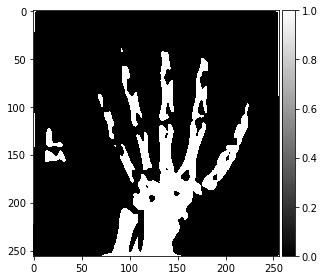

In [8]:
segm_img = train_df.iloc(0)[8]["masks"]
imshow(segm_img, cmap=plt.cm.gray)

In [9]:
train_df["flattened_masks"] = train_df["masks"].apply(lambda x: x.flatten())
train_df.head()

,id,boneage,male,file_paths,masks,flattened_masks
800,9727,120,False,./data/validation/9727.png,"[[[1], [0], [0], [0], [0], [0], [0], [0], [0],...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
801,9731,84,True,./data/validation/9731.png,"[[[1], [1], [1], [1], [1], [1], [1], [1], [1],...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
802,9743,113,False,./data/validation/9743.png,"[[[1], [0], [0], [0], [0], [0], [0], [0], [0],...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
803,9748,144,False,./data/validation/9748.png,"[[[1], [1], [0], [0], [0], [0], [0], [0], [0],...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
804,9755,106,False,./data/validation/9755.png,"[[[1], [1], [1], [1], [1], [1], [0], [0], [0],...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
X_train = np.array(train_df["flattened_masks"].values.tolist())
y_train = np.array(train_df["boneage"])

print(X_train.shape)
print(y_train.shape)

(625, 65536)
(625,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

In [14]:
%%time
from sklearn.ensemble import AdaBoostRegressor

svr = SVR(C=10, coef0=0.01, degree=3, gamma="scale", kernel="rbf")
ada_regr = AdaBoostRegressor(base_estimator=svr, n_estimators=10, loss="square")
ada_regr.fit(X_train, y_train)

preds = ada_regr.predict(X_test)
print(np.max((preds - y_test) / 12), "years")
print(np.min((preds - y_test) / 12), "years")

error = mean_absolute_error(y_test, preds)
print(error, " months")
print(error / 12, " years")

7.055990904512366 years
-7.58719503783814 years
29.212257730004254  months
2.4343548108336877  years
CPU times: user 23min 13s, sys: 15min 34s, total: 38min 47s
Wall time: 11min 35s


In [15]:
%%time
from sklearn.ensemble import BaggingRegressor

bag_regr = BaggingRegressor(base_estimator=svr, n_estimators=10)
bag_regr.fit(X_train, y_train)

preds = bag_regr.predict(X_test)
print(np.max((preds - y_test) / 12), "years")
print(np.min((preds - y_test) / 12), "years")

error = mean_absolute_error(y_test, preds)
print(error, " months")
print(error / 12, " years")

8.193753531493565 years
-6.80712572549741 years
28.722095896630425  months
2.3935079913858686  years
CPU times: user 5min 27s, sys: 3min 22s, total: 8min 49s
Wall time: 2min 54s


In [16]:
%%time
from sklearn.ensemble import AdaBoostRegressor

svr = SVR(C=10, coef0=0.01, degree=3, gamma="scale", kernel="rbf")
ada_regr = AdaBoostRegressor(n_estimators=10, loss="square")
ada_regr.fit(X_train, y_train)

preds = ada_regr.predict(X_test)
print(np.max((preds - y_test) / 12), "years")
print(np.min((preds - y_test) / 12), "years")

error = mean_absolute_error(y_test, preds)
print(error, " months")
print(error / 12, " years")

7.919238683127571 years
-7.598639455782313 years
28.892791760809516  months
2.4077326467341265  years
CPU times: user 13.3 s, sys: 1.64 s, total: 14.9 s
Wall time: 17.2 s


In [19]:
%%time
from sklearn.ensemble import BaggingRegressor

bag_regr = BaggingRegressor(n_estimators=10)
bag_regr.fit(X_train, y_train)

X_test
y_test
preds = bag_regr.predict(X_test)
print(np.max((preds - y_test) / 12), "years")
print(np.min((preds - y_test) / 12), "years")

error = mean_absolute_error(y_test, preds)
print(error, " months")
print(error / 12, " years")

9.85 years
-8.116666666666667 years
28.917600000000007  months
2.4098000000000006  years
CPU times: user 26.4 s, sys: 2.4 s, total: 28.8 s
Wall time: 30.4 s


In [11]:
train_df_men_only = train_df[train_df["male"] == True]

train_df_men_only.head()

,id,boneage,male,file_paths,masks,flattened_masks
801,9731,84,True,./data/validation/9731.png,"[[[1], [1], [1], [1], [1], [1], [1], [1], [1],...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
806,9760,168,True,./data/validation/9760.png,"[[[1], [1], [1], [0], [0], [0], [0], [0], [0],...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ..."
807,9764,156,True,./data/validation/9764.png,"[[[1], [0], [0], [0], [0], [0], [0], [0], [0],...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
809,9782,138,True,./data/validation/9782.png,"[[[1], [0], [0], [0], [0], [0], [0], [0], [0],...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
811,9832,150,True,./data/validation/9832.png,"[[[1], [1], [1], [1], [1], [1], [1], [1], [1],...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [12]:
X_train_male = np.array(train_df_men_only["flattened_masks"].values.tolist())
y_train_male = np.array(train_df_men_only["boneage"])
X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(X_train_male, y_train_male, 
                                                                        test_size = 0.2, random_state = 0)

In [13]:
train_df_women_only = train_df[train_df["male"] == False]

train_df_women_only.head()

,id,boneage,male,file_paths,masks,flattened_masks
800,9727,120,False,./data/validation/9727.png,"[[[1], [0], [0], [0], [0], [0], [0], [0], [0],...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
802,9743,113,False,./data/validation/9743.png,"[[[1], [0], [0], [0], [0], [0], [0], [0], [0],...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
803,9748,144,False,./data/validation/9748.png,"[[[1], [1], [0], [0], [0], [0], [0], [0], [0],...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
804,9755,106,False,./data/validation/9755.png,"[[[1], [1], [1], [1], [1], [1], [0], [0], [0],...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
805,9757,144,False,./data/validation/9757.png,"[[[1], [0], [0], [0], [0], [0], [0], [0], [0],...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
X_train_women = np.array(train_df_women_only["flattened_masks"].values.tolist())
y_train_women = np.array(train_df_women_only["boneage"])
X_train_women, X_test_women, y_train_women, y_test_women = train_test_split(X_train_women, y_train_women, 
                                                                        test_size = 0.2, random_state = 0)

In [16]:
opt_regressor = SVR(C=10, coef0=0.01, degree=3, gamma="scale", kernel="rbf")
opt_regressor.fit(X_train, y_train)

preds = opt_regressor.predict(X_test)
print(np.max((preds - y_test) / 12), "years")
print(np.min((preds - y_test) / 12), "years")

error = mean_absolute_error(y_test, preds)
print(error, " months")
print(error / 12, " years")

7.98471433069363 years
-6.934945648636742 years
28.679641737797535  months
2.3899701448164614  years


In [17]:
opt_regressor_m = SVR(C=10, coef0=0.01, degree=3, gamma="scale", kernel="rbf")
opt_regressor_m.fit(X_train_male, y_train_male)

preds = opt_regressor_m.predict(X_test_male)
print(np.max((preds - y_test_male) / 12), "years")
print(np.min((preds - y_test_male) / 12), "years")

error = mean_absolute_error(y_test_male, preds)
print(error, " months")
print(error / 12, " years")

8.870216624055876 years
-5.231316001759983 years
33.220569270439924  months
2.7683807725366605  years


In [18]:
opt_regressor_f = SVR(C=10, coef0=0.01, degree=3, gamma="scale", kernel="rbf")
opt_regressor_f.fit(X_train_women, y_train_women)

preds = opt_regressor_m.predict(X_test_women)
print(np.max((preds - y_test_women) / 12), "years")
print(np.min((preds - y_test_women) / 12), "years")

error = mean_absolute_error(y_test_women, preds)
print(error, " months")
print(error / 12, " years")

7.011867745184733 years
-3.534663566257533 years
31.59508478240684  months
2.6329237318672365  years


In [19]:
max(train_df["boneage"])

228

In [20]:
train_df_older = train_df[train_df["boneage"] > 120]

X_train_older = np.array(train_df_older["flattened_masks"].values.tolist())
y_train_older = np.array(train_df_older["boneage"])
X_train_older, X_test_older, y_train_older, y_test_older = train_test_split(X_train_older, y_train_older, 
                                                                        test_size = 0.2, random_state = 0)

In [22]:
opt_regressor_o = SVR(C=10, coef0=0.01, degree=3, gamma="scale", kernel="rbf")
opt_regressor_o.fit(X_train_older, y_train_older)

preds = opt_regressor_o.predict(X_test_older)
print(np.max((preds - y_test_older) / 12), "years")
print(np.min((preds - y_test_older) / 12), "years")

error = mean_absolute_error(y_test_older, preds)
print(error, " months")
print(error / 12, " years")

2.2334229081275865 years
-6.136889577629458 years
14.300017780311647  months
1.191668148359304  years


In [24]:
train_df_o2 = train_df[train_df["boneage"] > 156]

X_train_o2 = np.array(train_df_o2["flattened_masks"].values.tolist())
y_train_o2 = np.array(train_df_o2["boneage"])
X_train_o2, X_test_o2, y_train_o2, y_test_o2 = train_test_split(X_train_o2, y_train_o2, 
                                                                        test_size = 0.2, random_state = 0)

In [25]:
opt_regressor_o2 = SVR(C=10, coef0=0.01, degree=3, gamma="scale", kernel="rbf")
opt_regressor_o2.fit(X_train_o2, y_train_o2)

preds = opt_regressor_o2.predict(X_test_o2)
print(np.max((preds - y_test_o2) / 12), "years")
print(np.min((preds - y_test_o2) / 12), "years")

error = mean_absolute_error(y_test_o2, preds)
print(error, " months")
print(error / 12, " years")

0.6780356767637225 years
-4.007392584374107 years
12.296125627512257  months
1.0246771356260214  years


In [26]:
len(train_df)

625

In [29]:
len(train_df[train_df["boneage"] >= 120]) / len(train_df)

0.6416

In [28]:
len(train_df[train_df["male"] == True]) / len(train_df)

0.5168

In [67]:
opt_regressor = SVR(C=10, coef0=0.01, degree=3, gamma="scale", kernel="rbf")
opt_regressor.fit(X_train, y_train)

preds = opt_regressor.predict(X_test)
print(np.max((preds - y_test) / 12), "years")
print(np.min((preds - y_test) / 12), "years")

error = mean_absolute_error(y_test, preds)
print(error, " months")
print(error / 12, " years")

7.98471433069363 years
-6.934945648636742 years
28.679641737797535  months
2.3899701448164614  years


In [ ]:
regressor = SVR(kernel = 'linear')
regressor.fit(X_train, y_train)

preds = regressor.predict(X_test)
print(np.max((preds - y_test) / 12), "years")
print(np.min((preds - y_test) / 12), "years")

error = mean_absolute_error(y_test, preds)
print(error, " months")
print(error / 12, " years")

In [ ]:
param = {'kernel' : ('linear', 'rbf', 'sigmoid'),'C' : [1,5,10],'degree' : [3,8],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')},
param_search = GridSearchCV(SVR(), param, scoring='neg_mean_absolute_error', verbose = 3)

param_search.fit(X_train, y_train)

In [ ]:
param_search.best_params_

In [ ]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

preds = clf.predict(X_test)
print(np.max((preds - y_test) / 12), "years")
print(np.min((preds - y_test) / 12), "years")

error = mean_absolute_error(y_test, preds)
print(error, " months")
print(error / 12, " years")

In [ ]:
clf_rf = RandomForestRegressor(verbose = 1)
clf_rf.fit(X_train, y_train)

preds = clf_rf.predict(X_test)
print(np.max((preds - y_test) / 12), "years")
print(np.min((preds - y_test) / 12), "years")

error = mean_absolute_error(y_test, preds)
print(error, " months")
print(error / 12, " years")

In [ ]:
nn_model = keras.Sequential([
      tensorflow.keras.layers.Input((65536,)),
      tensorflow.keras.layers.Dense(128, activation='relu'),
      tensorflow.keras.layers.Dense(64, activation='relu'),
      tensorflow.keras.layers.Dense(64, activation='relu'),
      tensorflow.keras.layers.Dense(64, activation='relu'),
      tensorflow.keras.layers.Dense(1)
  ])

nn_model.compile(loss='mean_absolute_error', optimizer="adam")
nn_model.summary()

In [ ]:
nn_model.fit(X_train, y_train, epochs=50, validation_split=0.25, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)])

In [ ]:
preds = nn_model.predict(X_test)
print(np.max((preds - y_test) / 12), "years")
print(np.min((preds - y_test) / 12), "years")

error = mean_absolute_error(y_test, preds)
print(error, " months")
print(error / 12, " years")

In [20]:
men = len(train_df[train_df["male"] == True])

men

323

In [21]:
women = len(train_df[train_df["male"] == False])

women

302

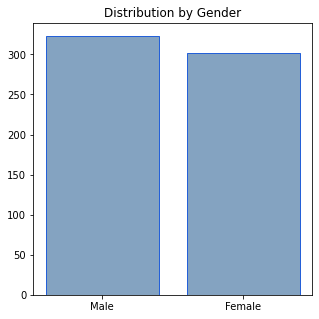

In [51]:
plt.figure(figsize=(5, 5))
plt.bar(["Male", "Female"], [men, women], color=(0.2, 0.4, 0.6, 0.6), edgecolor="#2460D8")
plt.title("Distribution by Gender")
plt.show()

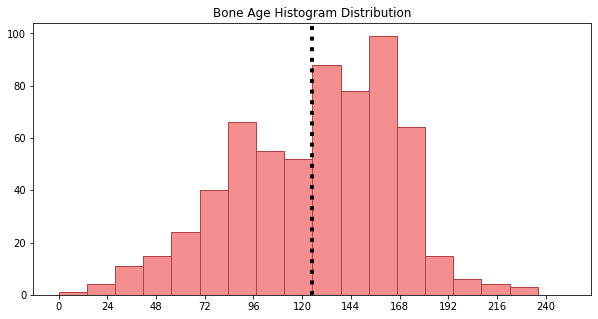

In [61]:
import matplotlib
plt.figure(figsize=(10, 5))
plt.hist(train_df["boneage"], bins=18, range=(0, 250), color="#f58f8fff", edgecolor="#af4345")
plt.axvline(125, color='k', linestyle='dotted', linewidth=4)
plt.title("Bone Age Histogram Distribution")
plt.xticks(range(0, 250, 24))
plt.show()

In [59]:
max(train_df["boneage"])

228

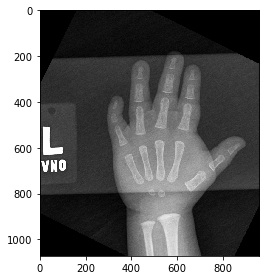

In [138]:
img = imread(train_df["file_paths"][1012])
imshow(img)

109.32361824948624


12

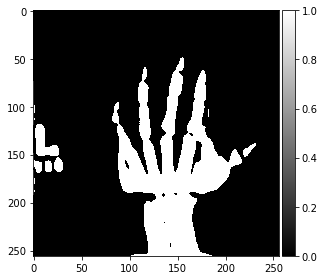

In [140]:
imshow(train_df["masks"][1012], cmap=plt.cm.gray)

print(np.min(preds))
train_df["boneage"][1012]